### Fetal Immune - Clustering for annotation

In this notebook we generate a coarse clustering of the batch corrected Fetal Immune Atlas to split into broad cell lineages on which we will do detailed reannotation. 

In [35]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from time import time
from datetime import datetime

### Load data

#### Preprocessed data

In [2]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210112.h5ad")

In [3]:
## Here I am adding the labels post-hoc
# These will be already saved in the anndata in future iterations
new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv", index_col=0)
adata.obs = new_obs

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Raw data

In [268]:
merged_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.h5ad')

merged_raw.obs['batch'] = [x+y for x,y in zip(merged_raw.obs['organ'],merged_raw.obs['method'])]
merged_raw.obs['bbk'] = [x+y for x,y in zip(merged_raw.obs['donor'],merged_raw.obs['method'])]

def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

obs_names = merged_raw.obs_names.values
gut_ixs = np.where(merged_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

merged_raw.obs_names = obs_names

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... storing 'Sample' as categorical
... storing 'donor' as categorical
... storing 'organ' as categorical
... storing 'method' as categorical
... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'batch' as categorical
... storing 'bbk' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical


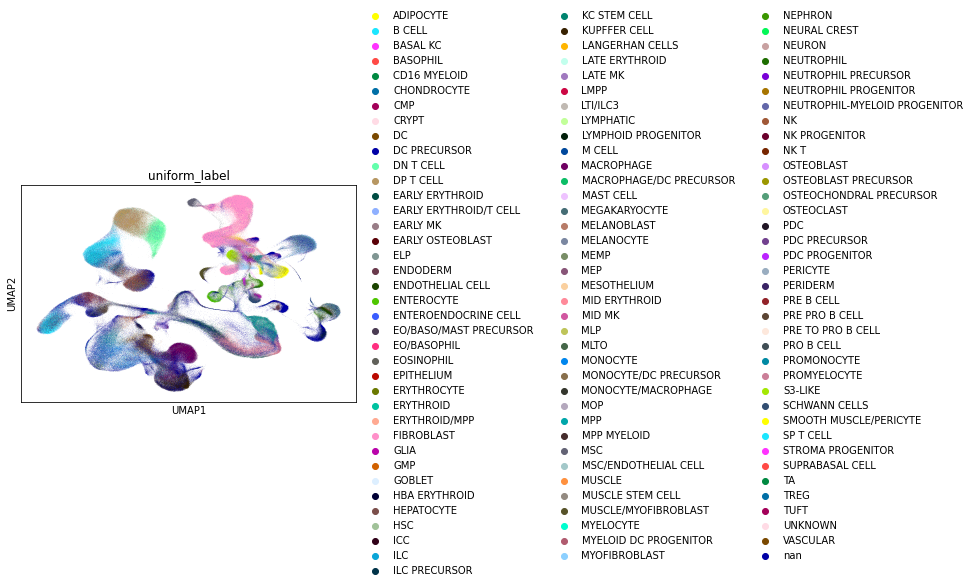

In [4]:
sc.pl.umap(adata, color="uniform_label")

### Clustering

Because louvain and leiden take a long time, try k-means for broad clustering 

In [89]:
from sklearn.cluster import MiniBatchKMeans
import sklearn.metrics

In [25]:
X = adata.obsm["X_pca"]

In [190]:
ARI_ls = []
k_ls = [10,20,30,40]
for k in k_ls:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0).fit(X)
    ARI_ls.append(sklearn.metrics.adjusted_rand_score(adata.obs['uniform_label_lvl0'], kmeans.labels_))

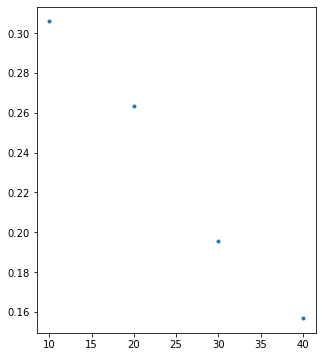

In [191]:
plt.rcParams["figure.figsize"] = [5,6]
plt.plot(k_ls, ARI_ls, '.')

In [192]:
adata.obs['kmeans_clusters'] = kmeans.labels_
adata.obs['kmeans_clusters'] = adata.obs['kmeans_clusters'].astype("category")

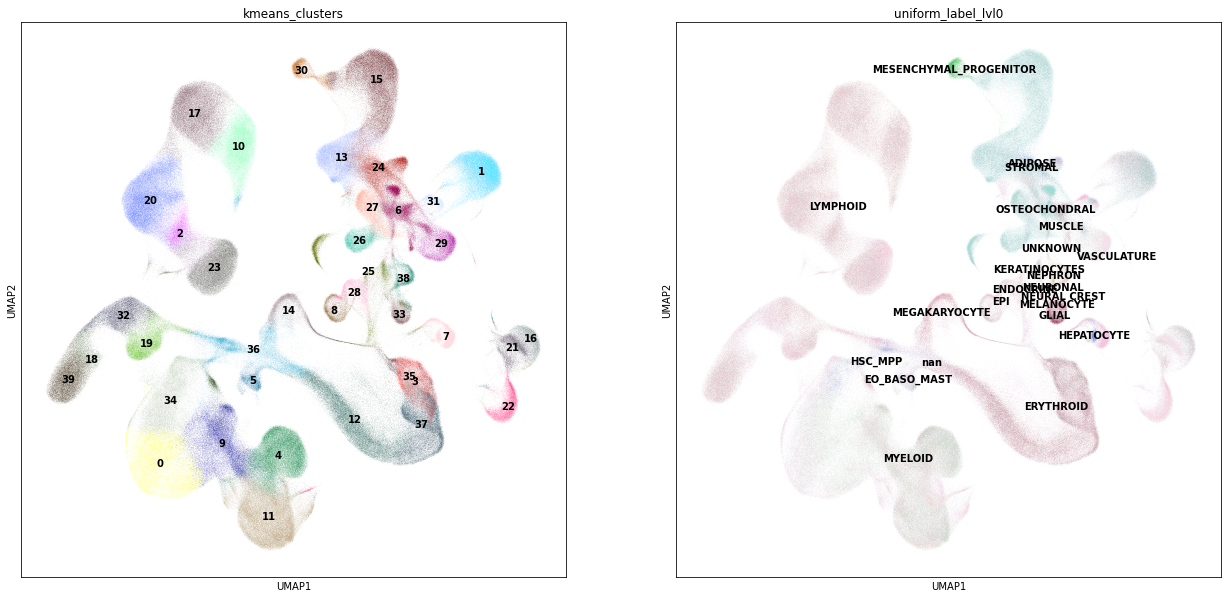

In [193]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=['kmeans_clusters','uniform_label_lvl0'], legend_loc="on data")

In [194]:
cl_counts = adata.obs.reset_index()[['kmeans_clusters', 'uniform_label_lvl0','index']] \
    .dropna() \
    .groupby(['kmeans_clusters', 'uniform_label_lvl0']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=["kmeans_clusters"], index=["uniform_label_lvl0"])

In [195]:
cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

In [196]:
pred_labels_df = pd.DataFrame(top_3_ls, columns=['kmeans_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

In [197]:
adata.obs["kmeans_pred_label"] = pred_labels_df.loc[adata.obs["kmeans_clusters"]]['kmeans_pred_label'].values

... storing 'kmeans_pred_label' as categorical


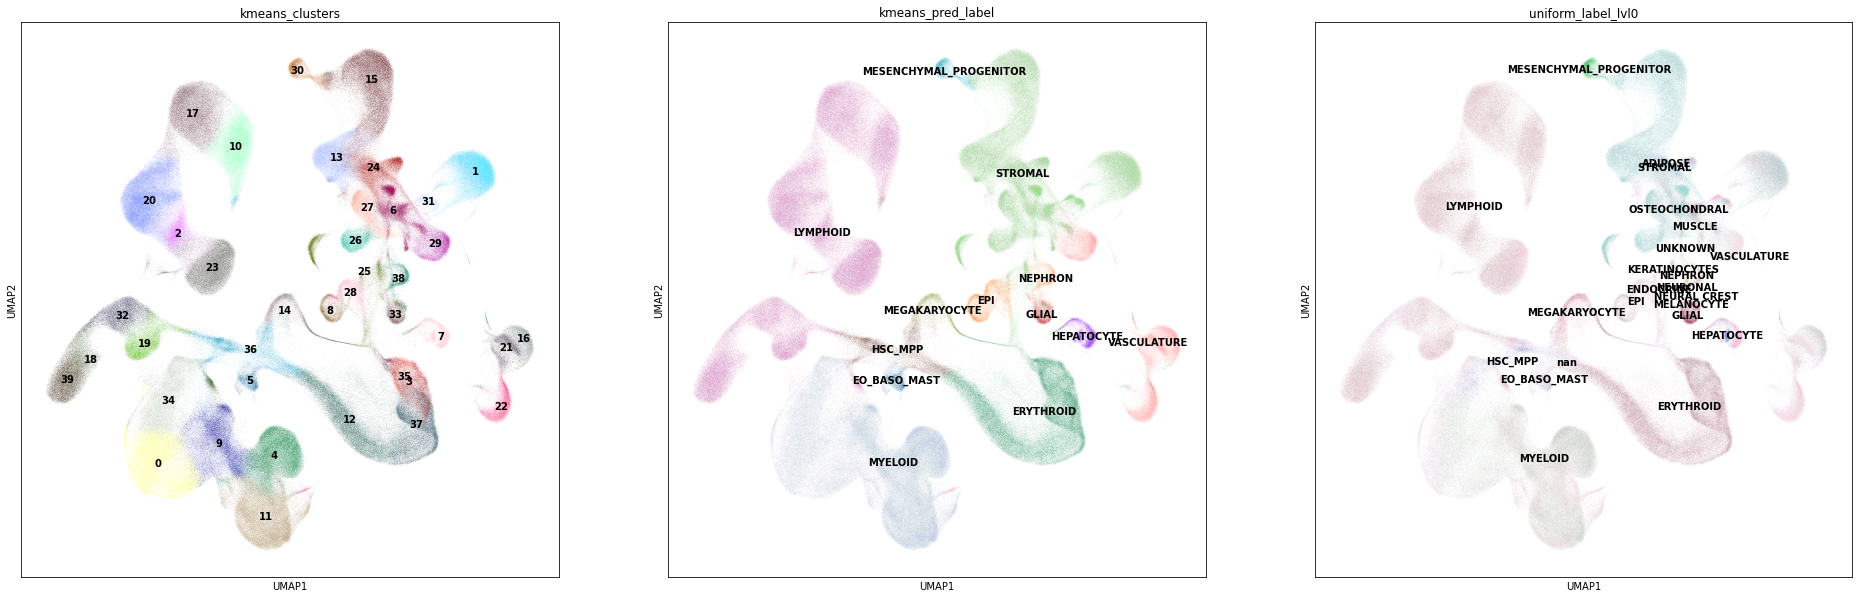

In [198]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=['kmeans_clusters','kmeans_pred_label','uniform_label_lvl0'], legend_loc="on data")

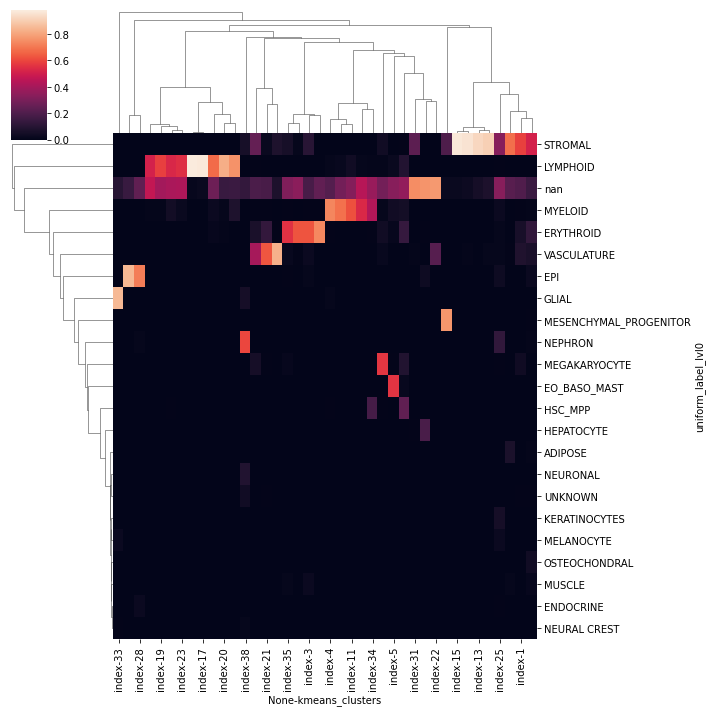

In [199]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.clustermap((cl_counts/cl_counts.sum(0)), 
#             norm=LogNorm()
           )

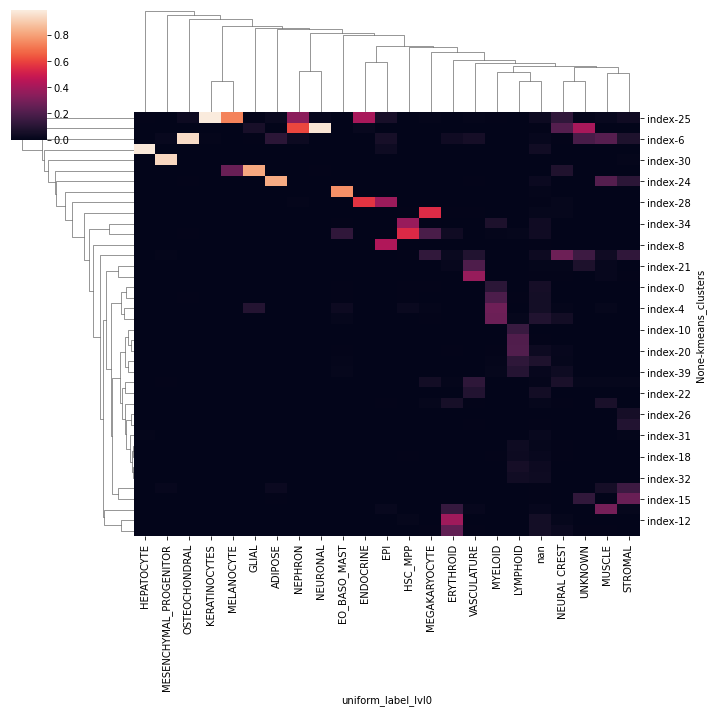

In [200]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.clustermap((cl_counts.T/cl_counts.sum(1)), 
#             norm=LogNorm()
           )

### Leiden clustering

In [204]:
start=datetime.now()
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_050', n_iterations=5)
lei_time = datetime.now()-start
print("Leiden runtime: ", str(lei_time))


Leiden runtime:  0:25:15.707417


In [215]:
start=datetime.now()
sc.tl.leiden(adata, resolution=1, key_added='leiden_100', n_iterations=5)
lei_time = datetime.now()-start
print("Leiden runtime: ", str(lei_time))

Leiden runtime:  0:24:36.271811


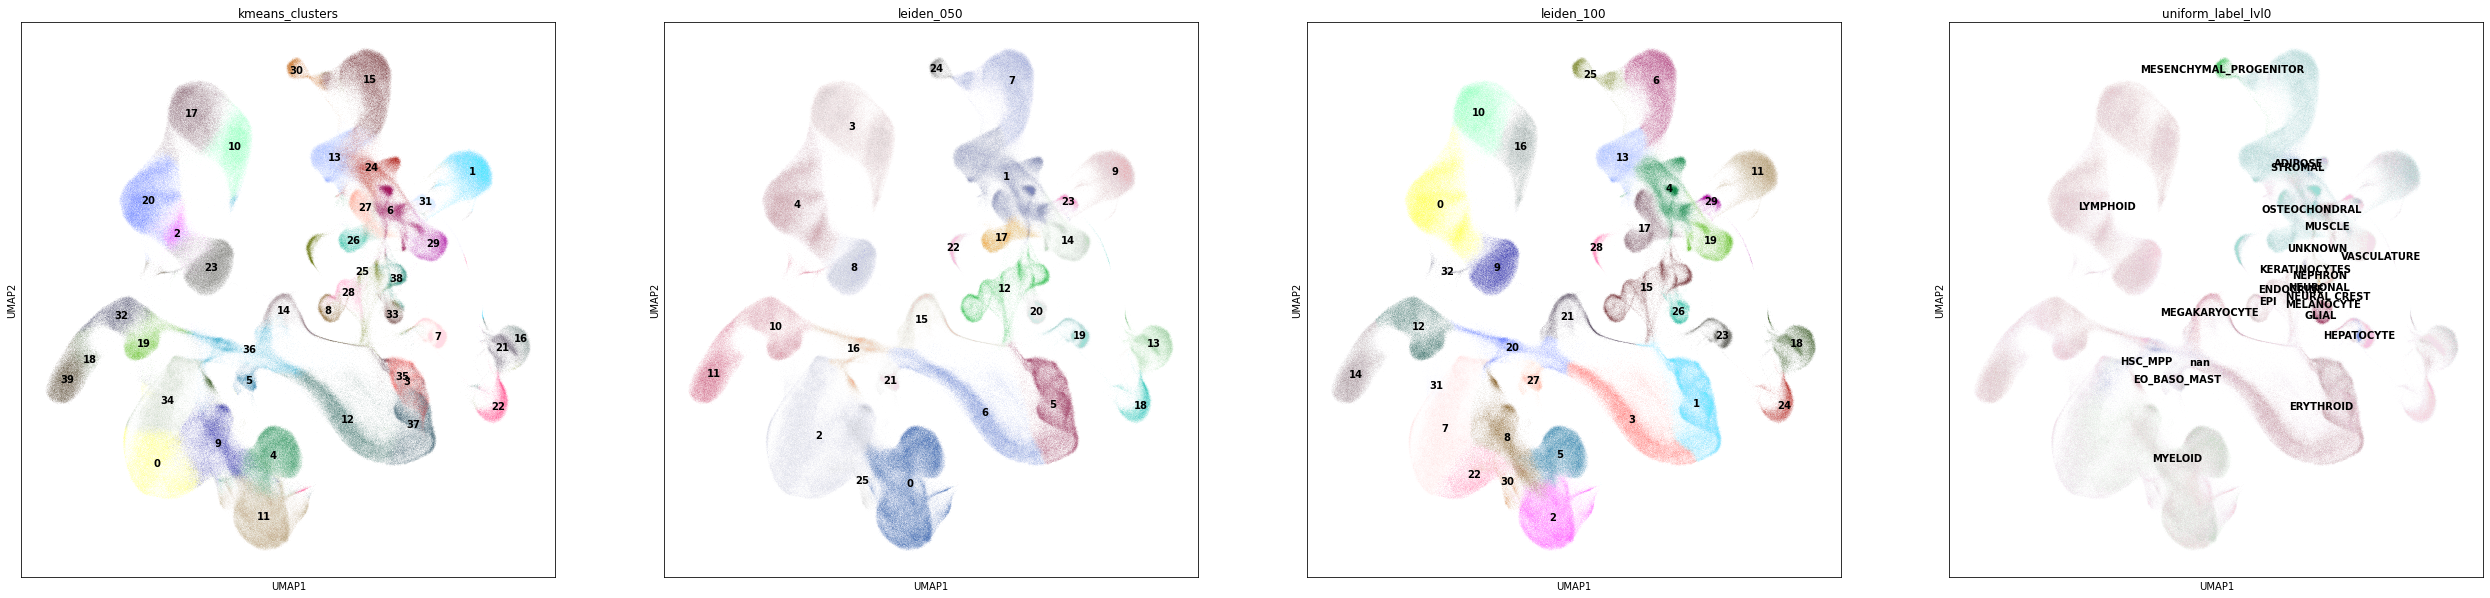

In [216]:
sc.pl.umap(adata, color=['kmeans_clusters','leiden_050','leiden_100', 'uniform_label_lvl0'], legend_loc="on data")

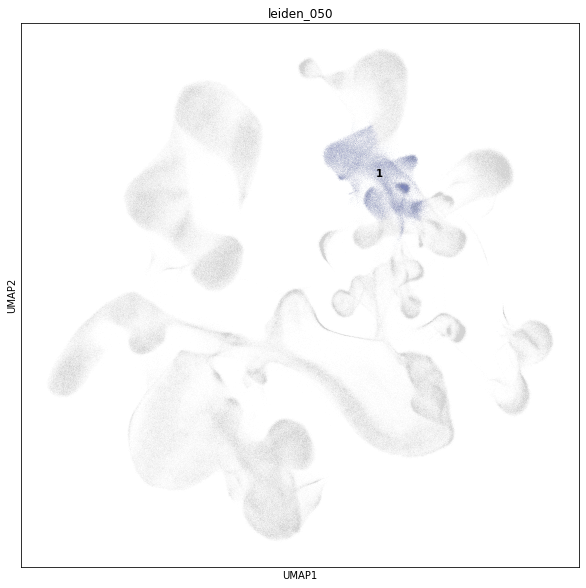

In [214]:
sc.pl.umap(adata, color=['leiden_050'], legend_loc="on data", groups=['1'])

In [213]:
sklearn.metrics.adjusted_rand_score(adata.obs['uniform_label_lvl0'], kmeans.labels_)
sklearn.metrics.adjusted_rand_score(adata.obs['uniform_label_lvl0'], adata.obs['leiden_050'])

0.15696785244573142

In [240]:
## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_lvl0', 'leiden_100','index']] \
    .dropna() \
    .groupby(['leiden_100', 'uniform_label_lvl0']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_100'], index=['uniform_label_lvl0'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_100_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_100_pred_label'] = pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label'].values

In [243]:
## Add predicted uniform label based on most frequent cell type
cl_counts = adata.obs.reset_index()[["uniform_label_expanded_merged", 'leiden_100','index']] \
    .dropna() \
    .groupby(['leiden_100', "uniform_label_expanded_merged"]) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_100'], index=["uniform_label_expanded_merged"])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_100_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_100_pred_label_expanded'] = pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label'].values

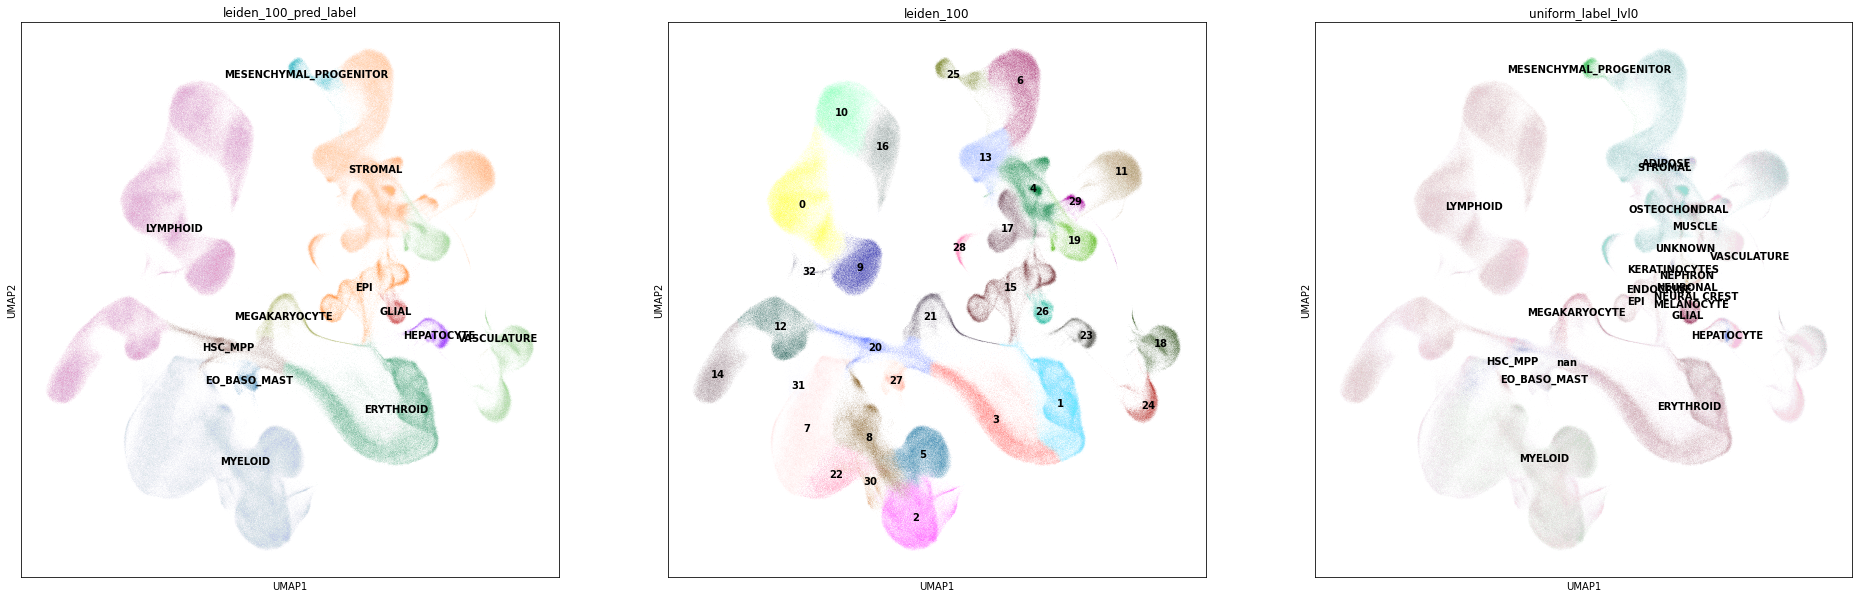

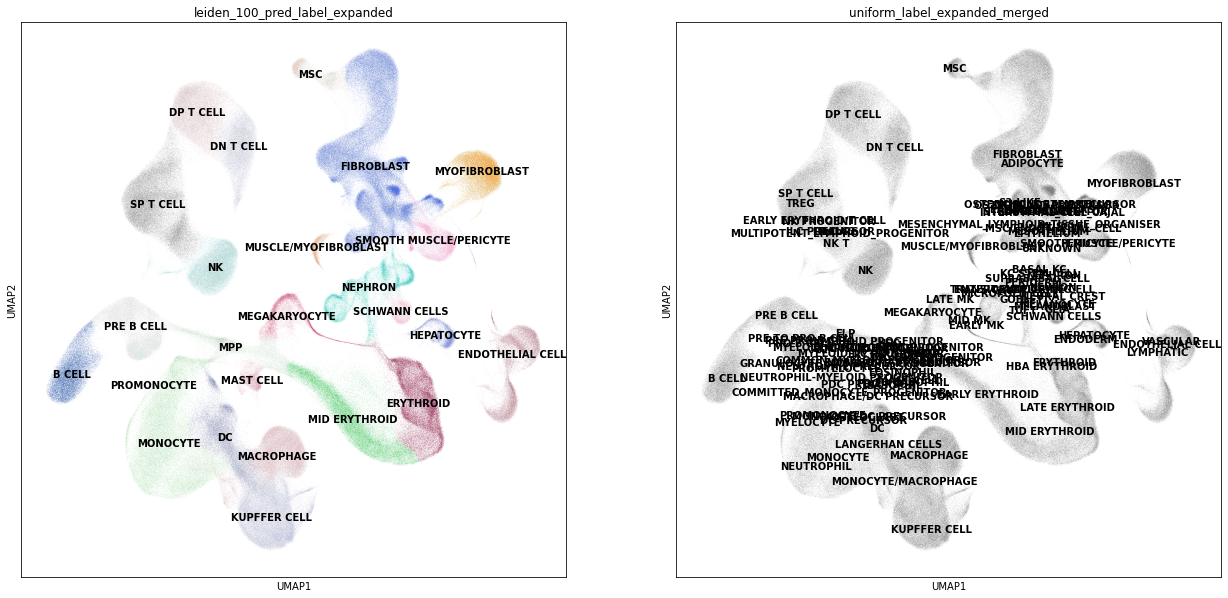

In [245]:
sc.pl.umap(adata, color=['leiden_100_pred_label','leiden_100', 'uniform_label_lvl0'], legend_loc="on data")
sc.pl.umap(adata, color=['leiden_100_pred_label_expanded',"uniform_label_expanded_merged"], legend_loc="on data")

Trying to set attribute `.uns` of view, copying.


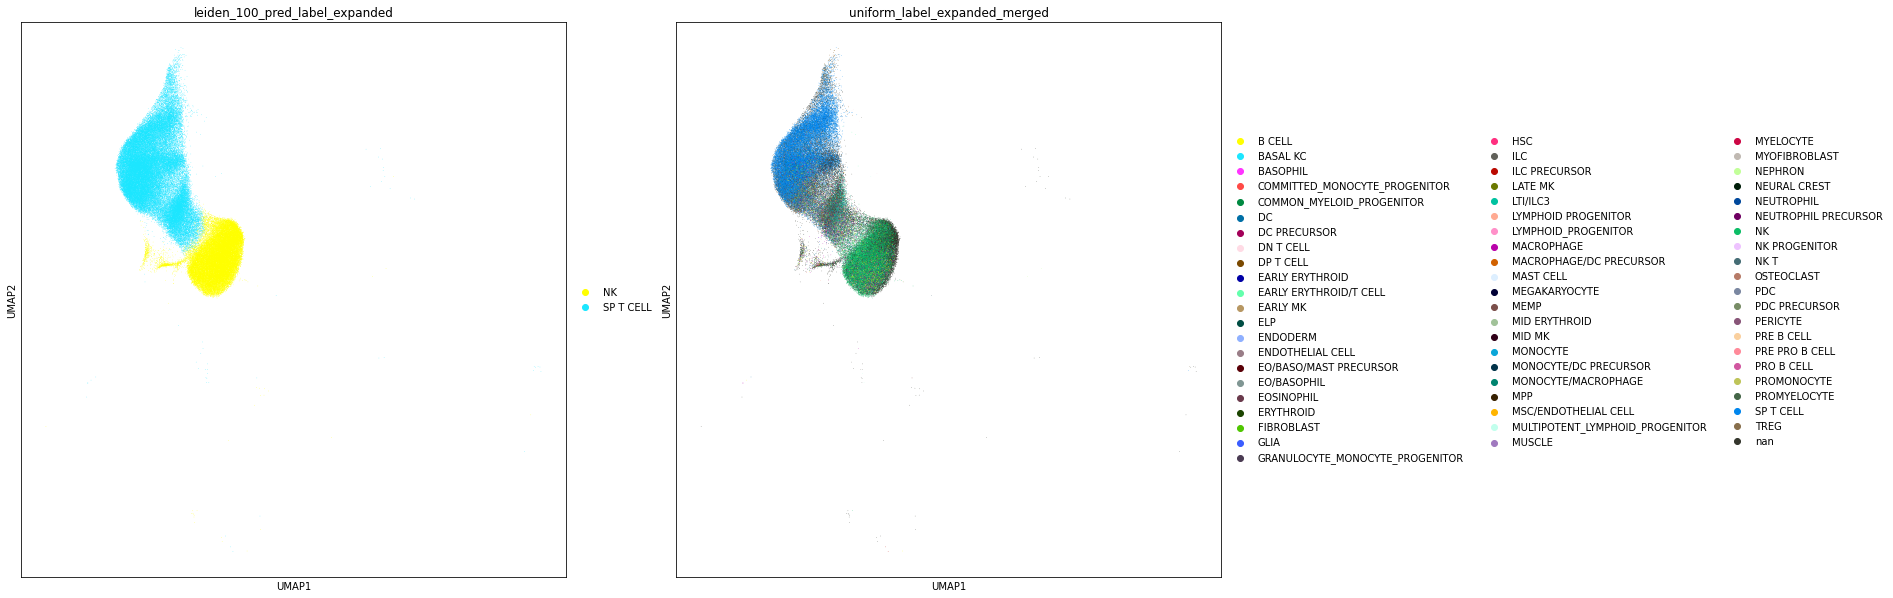

In [250]:
sc.pl.umap(adata[adata.obs['leiden_100_pred_label_expanded'].isin( ["SP T CELL","NK"] )], 
           color=['leiden_100_pred_label_expanded',"uniform_label_expanded_merged"], 
           palette=sc.plotting.palettes.default_102)

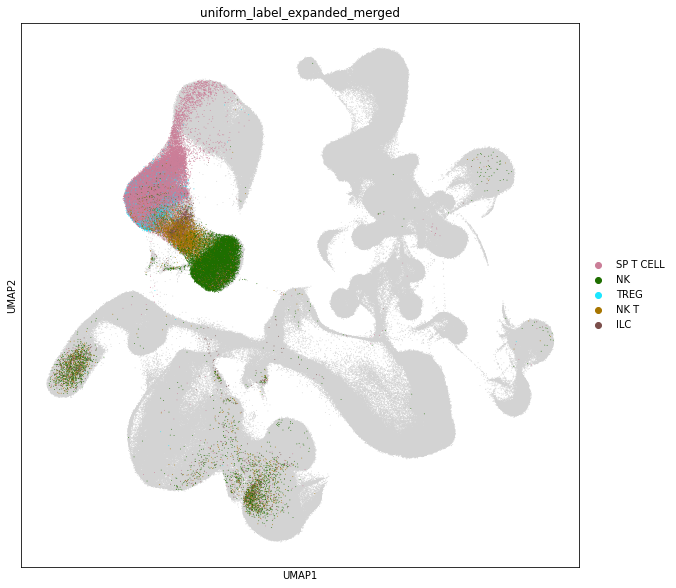

In [263]:
top_labels = [x for x in adata.obs[adata.obs['leiden_100_pred_label_expanded'].isin( ["SP T CELL","NK"] )].value_counts("uniform_label_expanded_merged")[0:6].index if x!="nan"]
sc.pl.umap(adata, 
           color=["uniform_label_expanded_merged"], groups=top_labels, size=3,
           palette=sc.plotting.palettes.default_102)

In [271]:
SPT_NK_ix = adata[adata.obs['leiden_100_pred_label_expanded'].isin( ["SP T CELL","NK"] )].obs_names

In [275]:
merged_raw.obs = adata.obs

In [292]:
merged_raw

AnnData object with n_obs × n_vars = 913795 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'method', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'Sample.lanes', 'Sort_id', 'age', 'sex', 'Processing_method', 'kmeans_clusters', 'kmeans_pred_label', 'leiden_050', 'leiden_100', 'leiden_100_pred_label', 'leiden_100_pred_label_expanded'
    var: 'GeneName', 'GeneID'

In [280]:
nkt_adata = adata[SPT_NK_ix]

In [281]:
sc.pp.pca(nkt_adata)

In [288]:
sc.pp.neighbors(nkt_adata, n_neighbors=20)
sc.tl.umap(nkt_adata)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovy

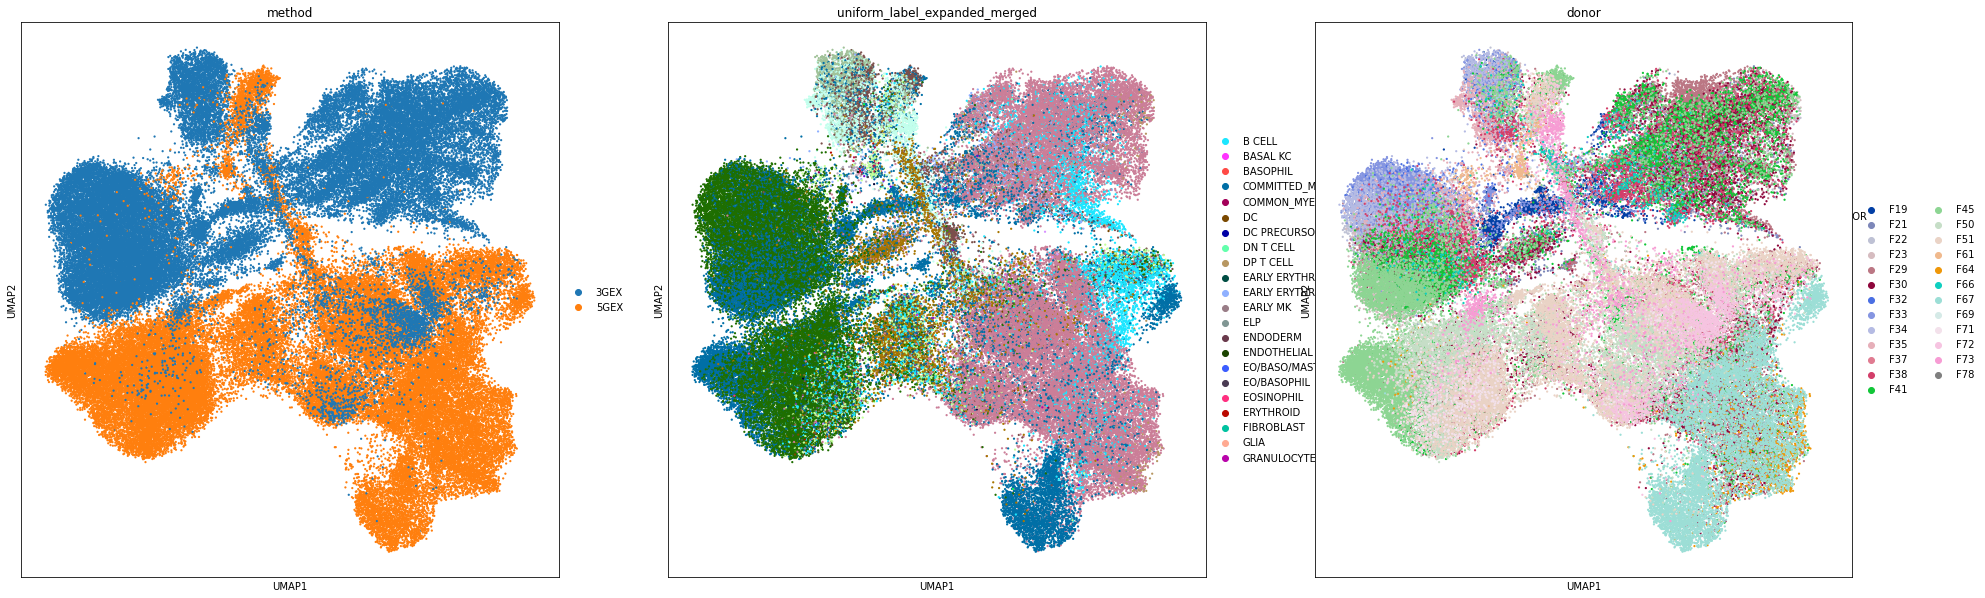

In [291]:
sc.pl.umap(nkt_adata, color=['method', "uniform_label_expanded_merged", 'donor'], size=20)

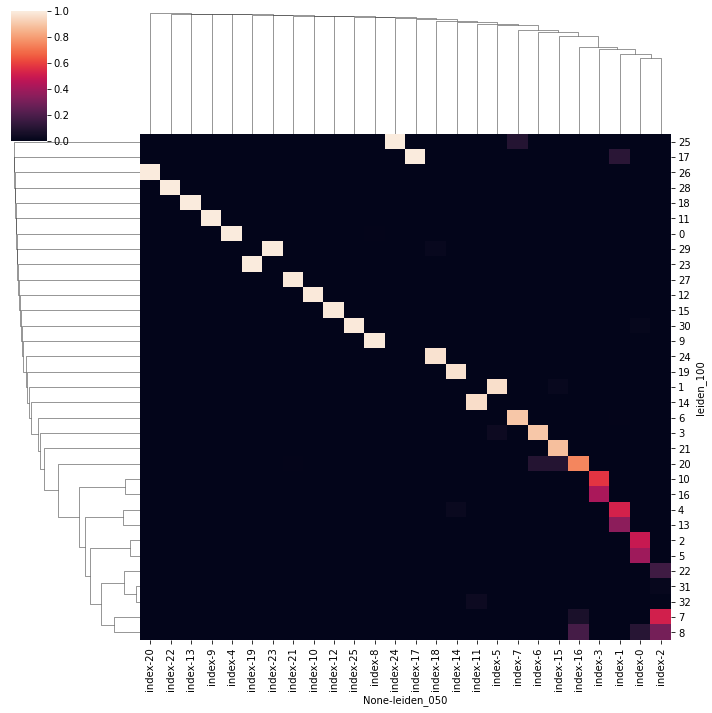

In [219]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.clustermap((cl_counts/cl_counts.sum(0)), 
#             norm=LogNorm()
           )

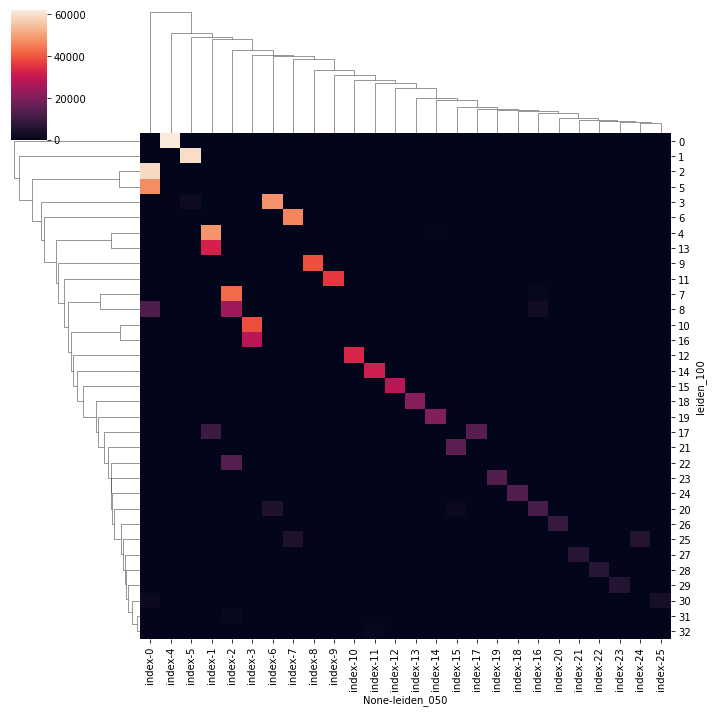

In [225]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.clustermap(cl_counts, 
#             norm=LogNorm()
           )

### Save output

In [294]:
## Save raw data with reductions

## Save clustering results
adata.obs.to_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210112.clustering.obs.csv")